# Importing libraries

In [2]:
# import libraries needed
import pandas as pd 
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data import and pre-processing

In [3]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset = pd.read_excel('/content/drive/My Drive/jedha fundies/Data/100k lines_Data NYC restaurants.xlsx')

In [5]:
dataset.head()

,ÔªøCAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50070206,BLUE CAFE RESTAURANT & BAR,Queens,8263,BROADWAY,11373.0,7183960717,Spanish,2018-11-01 00:00:00,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140¬∫ F.,Y,14.0,NaN,NaN,07/20/2020,Pre-permit (Operational) / Initial Inspection,40.741920,-73.881125,404.0,25.0,27100.0,4037524.0,4.015180e+09,QN29
1,41713504,ISIS RESTAURANT,Bronx,739,ALLERTON AVENUE,10467.0,7183241054,Mexican,2019-09-10 00:00:00,Establishment Closed by DOHMH. Violations wer...,08A,Facility not vermin proof. Harborage or condit...,N,40.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.865466,-73.865700,211.0,15.0,33800.0,2053637.0,2.045100e+09,BX07
2,41674628,MANHATTAN PROPER,Manhattan,6,MURRAY STREET,10007.0,6465594445,American,02/26/2019,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Y,20.0,B,02/26/2019,07/20/2020,Cycle Inspection / Re-inspection,40.713222,-74.007622,101.0,1.0,2100.0,1001407.0,1.001240e+09,MN24
3,50012117,ROBERTA'S PIZZA & BAKERY,Brooklyn,261,MOORE STREET,11206.0,7184171118,Pizza,2019-01-05 00:00:00,No violations were recorded at the time of thi...,NaN,NaN,NaN,0.0,NaN,NaN,07/20/2020,Inter-Agency Task Force / Initial Inspection,40.704818,-73.934015,301.0,34.0,48500.0,3071483.0,3.031010e+09,BK78
4,41022489,LA CANOA,Queens,651,ONDERDONK AVENUE,11385.0,7184566011,"Latin (Cuban, Dominican, Puerto Rican, South &...",02/24/2020,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or condit...,N,24.0,NaN,NaN,07/20/2020,Cycle Inspection / Initial Inspection,40.704525,-73.908126,405.0,34.0,54700.0,4082889.0,4.034670e+09,QN20


In [6]:
# cleaning the dataframe
# renaming columns
# deleting useless columns


dataset = dataset.rename(
    columns={
        "ÔªøCAMIS": "Restaurant ID",
        "DBA": "Restaurant Name",
        "CUISINE DESCRIPTION": "Cuisine"
            })

dataset = dataset.drop(["BUILDING", "PHONE", "Community Board", "Council District", "Census Tract", "BIN", "BBL", "NTA","Restaurant Name","Restaurant ID","STREET","ACTION","VIOLATION DESCRIPTION","INSPECTION TYPE","GRADE DATE","RECORD DATE","Latitude","Longitude", "ZIPCODE","INSPECTION DATE","CRITICAL FLAG","RECORD DATE"], axis=1)

In [7]:
dataset.head(15)

,BORO,Cuisine,VIOLATION CODE,SCORE,GRADE
0,Queens,Spanish,02B,14.0,NaN
1,Bronx,Mexican,08A,40.0,NaN
2,Manhattan,American,04L,20.0,B
3,Brooklyn,Pizza,NaN,0.0,NaN
4,Queens,"Latin (Cuban, Dominican, Puerto Rican, South &...",08A,24.0,NaN
5,Manhattan,Japanese,08A,11.0,A
6,Staten Island,Vietnamese/Cambodian/Malaysia,10F,8.0,A
7,Bronx,Spanish,10B,10.0,A
8,Queens,Korean,06C,32.0,NaN
9,Manhattan,Italian,04L,27.0,NaN


In [8]:
dataset.isnull().sum()

BORO                  0
Cuisine               0
VIOLATION CODE     2309
SCORE              6502
GRADE             74275
dtype: int64

In [9]:
# removing rows with no score or grade
dataset = dataset.dropna(subset=['SCORE','GRADE'])

# checking
dataset.isnull().sum()

BORO                0
Cuisine             0
VIOLATION CODE    387
SCORE               0
GRADE               0
dtype: int64

## Dummy-fying borough values

In [10]:
# turn qualitative values into quantitative
# starting with boro
dummies_boro = pd.get_dummies(dataset['BORO'], drop_first=True)
dummies_boro.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,1,0,0,0,0
10,0,0,1,0,0


In [11]:
dataset = dataset.merge(dummies_boro, left_index=True, right_index=True)
dataset.head()

,BORO,Cuisine,VIOLATION CODE,SCORE,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island
2,Manhattan,American,04L,20.0,B,0,0,1,0,0
5,Manhattan,Japanese,08A,11.0,A,0,0,1,0,0
6,Staten Island,Vietnamese/Cambodian/Malaysia,10F,8.0,A,0,0,0,0,1
7,Bronx,Spanish,10B,10.0,A,1,0,0,0,0
10,Manhattan,Seafood,10B,13.0,A,0,0,1,0,0


## Merging cuisine types for easier data analysis
We have 84 different cuisine types. It will be easier to merge them into categories to understand the data and see which features have influence in our models.
We will group cuisine types by continent.

In [12]:
dataset.Cuisine.nunique()

84

In [13]:
dataset.Cuisine.unique()

array(['American', 'Japanese', 'Vietnamese/Cambodian/Malaysia', 'Spanish',
       'Seafood', 'Donuts', 'Indian', 'Delicatessen', 'Chicken', 'French',
       'Bakery', 'Chinese', 'Caribbean', 'Turkish',
       'Bottled beverages, including water, sodas, juices, etc.', 'Thai',
       'Hamburgers', 'Jewish/Kosher', 'Ice Cream, Gelato, Yogurt, Ices',
       'Hotdogs', 'Vegetarian', 'Pizza', 'Greek', 'Caf√©/Coffee/Tea',
       'Steak', 'Armenian', 'African', 'Tex-Mex', 'Filipino',
       'Juice, Smoothies, Fruit Salads', 'Mexican', 'Pizza/Italian',
       'Korean', 'Asian',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'Italian', 'Soul Food', 'Russian', 'Brazilian', 'Mediterranean',
       'Chinese/Cuban', 'Bagels/Pretzels', 'Continental', 'Peruvian',
       'Bangladeshi', 'Eastern European',
       'Sandwiches/Salads/Mixed Buffet', 'English', 'Other', 'Irish',
       'Ethiopian', 'Hawaiian', 'Sandwiches', 'Salads', 'Middle Eastern',
       'Moroccan', 'B

In [14]:
dataset['Cuisine'] = dataset['Cuisine'].replace(['Iranian','Middle Eastern','Indonesian','Bangladeshi','Afghan','Indian','Turkish','Japanese','Vietnamese/Cambodian/Malaysia','Korean','Asian','Filipino','Chinese/Japanese','Chinese','Thai'],'Asia')
dataset['Cuisine'] = dataset['Cuisine'].replace(['Spanish','Italian','French','English','Eastern European','Mediterranean','Greek','Russian','German','Irish','Polish','Portuguese','Czech','Basque','Scandinavian'],'Europe')
dataset['Cuisine'] = dataset['Cuisine'].replace(['American','Donuts','Caribbean','Tex-Mex','Mexican','Latin (Cuban, Dominican, Puerto Rican, South & Central American)','Brazilian','Chinese/Cuban','Soul Food','Peruvian','Bagels/Pretzels','Hawaiian','Barbecue','Southwestern','Cajun','Creole/Cajun','Californian','Chilean'], 'Americas')
dataset['Cuisine'] = dataset['Cuisine'].replace(['Ethiopian','Egyptian','Moroccan'],'Africa')
dataset['Cuisine'] = np.where(dataset['Cuisine'].isin(['Asia','Africa','Americas','Europe']), dataset['Cuisine'], 'Others')
print(dataset.Cuisine.unique())
print(dataset.Cuisine.nunique())

['Americas' 'Asia' 'Europe' 'Others' 'Africa']
5


## Dummy-fying cuisine and violation codes

In [15]:
# same thing with cuisine and violation code
dummies_cuisine = pd.get_dummies(dataset['Cuisine'], drop_first=True)
dataset = dataset.merge(dummies_cuisine, left_index=True, right_index=True)
dummies_code = pd.get_dummies(dataset['VIOLATION CODE'], drop_first=True)
dataset = dataset.merge(dummies_code, left_index=True, right_index=True)

In [16]:
# creating a second dataframe where we remove GRADE as we first need only numeric values for the multivariate linear regression
dataset_num = dataset.drop(['BORO','Cuisine','VIOLATION CODE','GRADE'], axis=1)

In [17]:
dataset_num.head(5)

,SCORE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Americas,Asia,Europe,Others,02B,02C,02D,02E,02F,02G,02H,02I,03A,03B,03C,03D,03E,03G,04A,04B,04C,04D,04E,04F,04G,04H,04J,04K,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,22F,22G
2,20.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,11.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,8.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,10.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,13.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Linear regression multi-variable

In [18]:
# defining X and y, y being the SCORE and X being all other columns *not SCORE*
y = dataset_num["SCORE"].values.astype(int)
X = dataset_num.drop("SCORE", axis=1)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X_train, y_train)


print("Score Train:",reg.score (X_train, y_train))
print("Score Test:",reg.score (X_test, y_test))

Score Train: 0.11014299991276166
Score Test: 0.10292230742169317


In [21]:
predictions = reg.predict(X_test)
print(predictions[0:50])

[16.79837292 15.52946027 15.1278309   9.14394543 11.34134245 13.08137235
 11.15363052  9.3920977  14.53380476 12.06476865 11.15363052 15.9231062
 16.3053099  10.70662533  9.22870077  9.14394543  9.22870077 11.71460566
 13.64130181  9.62016523 14.5530025  19.41995845 14.47422818 14.5530025
 10.75081422 11.27320747 14.65161109 11.40796263 15.01002456 13.37789949
  9.80352916 10.62186999  9.80352916  9.25134035 16.3053099  12.06476865
 11.68002379 14.45563974  9.70492057  9.80352916 13.13530877  9.3920977
 13.47252342  9.32730936 12.72956291 15.94087064 16.55029864 15.1278309
 11.71460566 15.73195781]


In [22]:
# comparing predictions vs y_test
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(predictions_df.head(10))

   Actual  Predicted
0      11  16.798373
1      11  15.529460
2      12  15.127831
3       4   9.143945
4       9  11.341342
5      13  13.081372
6       5  11.153631
7      12   9.392098
8      12  14.533805
9      12  12.064769


Text(0.5, 1.0, 'Actual scores vs model predictions')

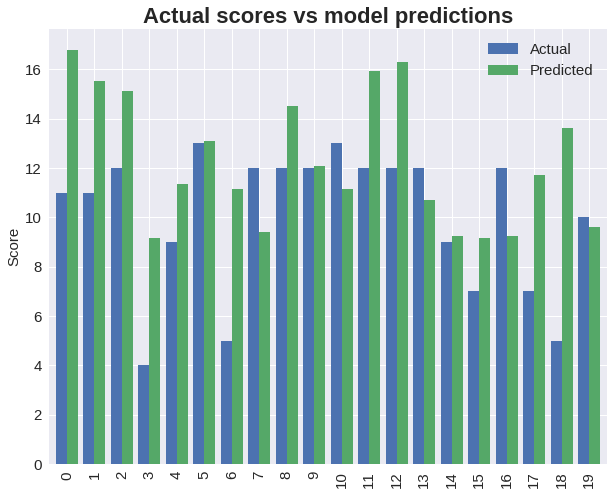

In [23]:
# plotting actual vs predicted values
pred_plot = predictions_df.head(20)
pred_plot.plot(kind='bar',figsize=(10,8), fontsize=15, width=0.8)
plt.ylabel('Score', fontsize=15)
plt.legend(fontsize= 15)
plt.title('Actual scores vs model predictions', fontsize=22, fontweight='bold')

# Decision tree modeling

## First tree

In [24]:
# we take our 'initial' dataset and drop SCORE
dataset = dataset.drop(['SCORE'], axis=1)
dataset.head(5)

,BORO,Cuisine,VIOLATION CODE,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Americas,Asia,Europe,Others,02B,02C,02D,02E,02F,02G,02H,02I,03A,03B,03C,03D,03E,03G,04A,04B,04C,04D,04E,04F,04G,04H,04J,04K,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,22F,22G
2,Manhattan,Americas,04L,B,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Manhattan,Asia,08A,A,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Staten Island,Asia,10F,A,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,Bronx,Europe,10B,A,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,Manhattan,Others,10B,A,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
# dropping non dummies columns
dataset = dataset.drop(['BORO','Cuisine','VIOLATION CODE'], axis=1)
dataset.head(5)

,GRADE,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Americas,Asia,Europe,Others,02B,02C,02D,02E,02F,02G,02H,02I,03A,03B,03C,03D,03E,03G,04A,04B,04C,04D,04E,04F,04G,04H,04J,04K,04L,04M,04N,04O,05A,05B,05C,05D,05E,05F,05H,06A,06B,06C,06D,06E,06F,06G,06H,06I,07A,08A,08B,08C,09A,09B,09C,10A,10B,10C,10D,10E,10F,10G,10H,10I,10J,22F,22G
2,B,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,A,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,A,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,A,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10,A,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
# removing grades that aren't A/B/C (the other letter grades mean that the grade is pending and thus aren't useful here)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'N')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'Z')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'P')].index)
dataset = dataset.drop(dataset[(dataset['GRADE'] == 'G')].index)
dataset.GRADE.unique()

array(['B', 'A', 'C'], dtype=object)

In [27]:
# defining X and y, y being the GRADE and X being all other columns *not GRADE*
y = dataset["GRADE"]
X = dataset.drop("GRADE", axis=1)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
# evaluating model scores
print("Score train:", classifier.score(X_train, y_train))
print("Score test:", classifier.score(X_test, y_test))

Score train: 0.563433411635603
Score test: 0.5512653453123928


In [31]:
pred_tree = classifier.predict(X_test)
# comparing predictions vs y_test
pred_tree_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_tree})
pred_tree_df.head(75)

,Actual,Predicted
69246,A,B
123779,B,B
78265,A,A
4374,A,B
51306,A,B
...,...,...
60108,C,B
139476,B,B
53533,C,A
18607,A,A


In [32]:
# split of predictions by categories
print(np.unique(pred_tree, return_counts=True))

(array(['A', 'B', 'C'], dtype=object), array([7677, 4013, 2891]))


In [71]:
# putting feature importance in a dataframe
feature_importance = pd.DataFrame({"Features":dataset.columns[:-1],
                                    "Value": classifier.feature_importances_})

# getting the top 10
feature_importance.nlargest(10, 'Value')

,Features,Value
65,10E,0.179811
1,Bronx,0.053552
2,Brooklyn,0.046976
47,06C,0.044091
5,Staten Island,0.043883
3,Manhattan,0.043216
7,Asia,0.041835
8,Europe,0.041203
6,Americas,0.039466
0,GRADE,0.035771


## Second tree

In [34]:
classifier2 = DecisionTreeClassifier(min_samples_split=60, max_depth=200)
classifier2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=200, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=60,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [35]:
print("Score train:", classifier2.score(X_train, y_train))
print("Score test:", classifier2.score(X_test, y_test))

Score train: 0.8245057526448449
Score test: 0.8202455249982854


In [36]:
np.unique(classifier2.predict(X_test), return_counts=True)

(array(['A', 'B', 'C'], dtype=object), array([14540,    21,    20]))

=> We barely improve the test score with different hyperparameters.

# Random forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
print("Score train:",forest.score(X_train, y_train))
print("Score test:",forest.score(X_test, y_test))

Score train: 0.5823288352394507
Score test: 0.5709484946162815


In [39]:
pred_forest = forest.predict(X_test)
# comparing predictions vs y_test
pred_forest_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_forest})
pred_forest_df.head(75)

,Actual,Predicted
69246,A,B
123779,B,B
78265,A,A
4374,A,B
51306,A,B
...,...,...
60108,C,B
139476,B,B
53533,C,A
18607,A,A


In [67]:
# split predictions
print("predictions:", np.unique(pred_forest, return_counts=True))

predictions: (array(['A', 'B', 'C'], dtype=object), array([7981, 4233, 2367]))


In [53]:
# confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['A', 'B', 'C']
cm = confusion_matrix(y_test, forest.predict(X_test), labels)
cm

array([[7212, 3052, 1700],
       [ 517,  910,  464],
       [ 252,  271,  203]])

[Text(0, 0.5, 'A'), Text(0, 1.5, 'B'), Text(0, 2.5, 'C')]

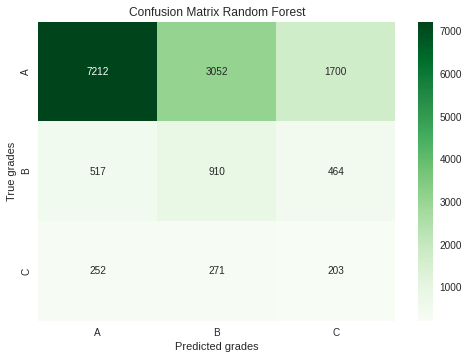

In [58]:
ax = plt.subplot()
sb.heatmap(cm, annot=True, fmt=".0f", cmap='Greens', ax = ax)
ax.set_xlabel('Predicted grades')
ax.set_ylabel('True grades')
ax.set_title('Confusion Matrix Random Forest')
ax.xaxis.set_ticklabels(['A', 'B', 'C']); ax.yaxis.set_ticklabels(['A', 'B', 'C'])

In [59]:
# putting feature importance in a dataframe
feature_importance_forest = pd.DataFrame({"Features":dataset.columns[:-1],
                                    "Value": forest.feature_importances_})

# getting the top 10
feature_importance_forest.nlargest(10, 'Value')

,Features,Value
65,10E,0.116771
2,Brooklyn,0.049512
1,Bronx,0.045689
3,Manhattan,0.045540
5,Staten Island,0.040224
8,Europe,0.037586
0,GRADE,0.037238
7,Asia,0.035751
6,Americas,0.035414
4,Queens,0.027061


# Naive classification

In [62]:
from sklearn.naive_bayes import GaussianNB
naiveb = GaussianNB()
naiveb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [66]:
print("Score train:",naiveb.score(X_train, y_train))
print("Score test:",naiveb.score(X_test, y_test))

Score train: 0.5565748186759486
Score test: 0.554077223784377


In [63]:
pred_naiveb = naiveb.predict(X_test)
pred_naiveb_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred_naiveb})
pred_naiveb_df.head(75)

,Actual,Predicted
69246,A,C
123779,B,C
78265,A,A
4374,A,C
51306,A,C
...,...,...
60108,C,C
139476,B,A
53533,C,A
18607,A,A


=> our random forest classifier score is higher than the naive classifier score.